# Pronóstico del índice Maximo Ultravioleta Diario (UVMAX) usando Modelo SARIMAX

## Carga de Datos

In [1]:
import pandas as pd

df_train = pd.read_csv('df_trainv2.csv')
df_test = pd.read_csv('df_testv2.csv')

df_train = df_train[['UV_MAX']]

## Modelado SARIMAX

In [2]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df_train['UV_MAX'],
                order=(1,0,1),
                seasonal_order=(1,1,1,91),
                enforce_stationarity=False,
                enforce_invertibility=False)

result = model.fit()
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             UV_MAX   No. Observations:                  730
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 91)   Log Likelihood               -1204.101
Date:                            Tue, 08 Jul 2025   AIC                           2418.202
Time:                                    21:36:56   BIC                           2439.715
Sample:                                         0   HQIC                          2426.612
                                            - 730                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8908      0.039     22.956      0.000       0.815       0.967
ma.L1         -0.6935      0.058   

## Generación de Pronósticos (365 días)

In [3]:
predicciones = result.get_forecast(steps=365)

pred_mean = predicciones.predicted_mean
conf_int = predicciones.conf_int()

pred_mean.index = df_test.index
conf_int.index = df_test.index


df_resultado = df_test.copy()
df_resultado['UV_MAX_Pronosticado'] = pred_mean
df_resultado['IC_inf'] = conf_int.iloc[:, 0]
df_resultado['IC_sup'] = conf_int.iloc[:, 1]

df_resultado

,FECHA,O3,UV_MAX,PP,UV_MAX_Pronosticado,IC_inf,IC_sup
0,2022-06-01,242.8,8.0,0.0,9.463363,5.326984,13.599741
1,2022-06-02,242.8,8.0,0.0,8.842370,4.626288,13.058451
2,2022-06-03,242.8,8.0,0.0,9.905761,5.627494,14.184028
3,2022-06-04,239.6,8.0,3.4,10.363295,6.036322,14.690269
4,2022-06-05,240.4,9.0,0.2,9.715443,5.350209,14.080677
...,...,...,...,...,...,...,...
360,2023-05-27,238.2,8.0,2.4,9.188326,4.216872,14.159780
361,2023-05-28,242.7,5.0,2.2,10.103208,5.131773,15.074642
362,2023-05-29,243.0,8.0,0.2,9.139715,4.168786,14.110645
363,2023-05-30,243.0,9.0,0.2,10.217631,5.246701,15.188561


## Visualización: Pronóstico vs Real

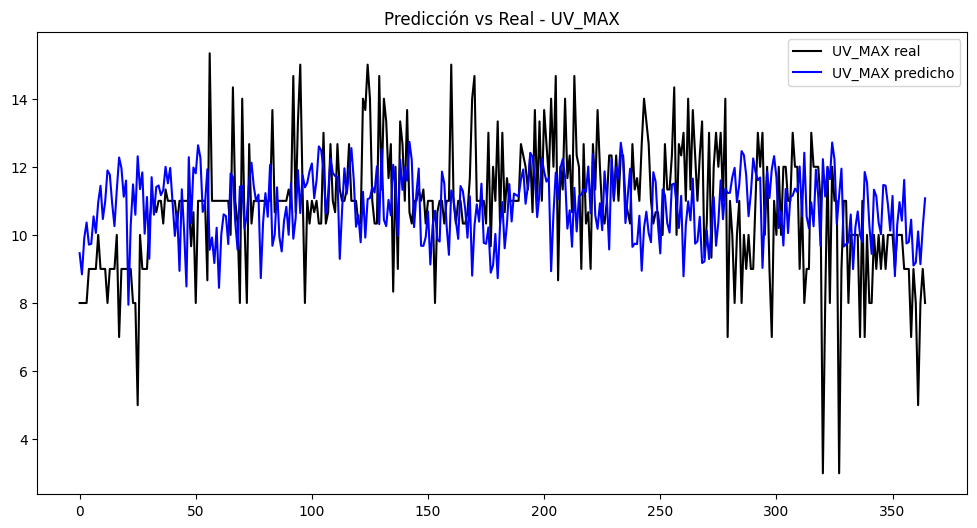

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_test['UV_MAX'], label='UV_MAX real', color='black')
plt.plot(df_resultado['UV_MAX_Pronosticado'], label='UV_MAX predicho', color='blue')
plt.title('Predicción vs Real - UV_MAX')
plt.legend()
plt.show()


## Visualización del Pronóstico a Futuro (91 pasos)

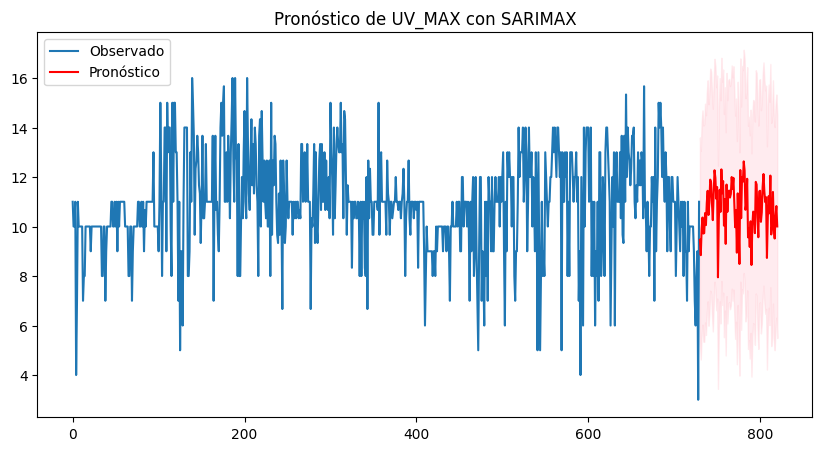

In [5]:
pred = result.get_forecast(steps=91)
conf_int = pred.conf_int()

plt.figure(figsize=(10,5))
plt.plot(df_train.index, df_train['UV_MAX'], label='Observado')
plt.plot(pred.predicted_mean.index, pred.predicted_mean, label='Pronóstico', color='red')
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.title('Pronóstico de UV_MAX con SARIMAX')
plt.show()


# Evaluación del Modelo

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = df_resultado['UV_MAX_Pronosticado']
y_true = df_test['UV_MAX']

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

mean_real = y_true.mean()
mae_rel = mae / mean_real * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")
print(f"MAE Relativo: {mae_rel:.2f}%")

MAE: 1.55
RMSE: 2.06
R²: -0.30
MAE Relativo: 14.33%
